# Supervised Learning

# 05_supervised_learning_model

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 30/10/2025   | Martin | Created   | Notebook created for supervised learning model | 
| 01/10/2025   | Martin | New   | Added XGBoost and FFNN sections | 
| 05/10/2025   | Martin | Updated   | Tested on dummy target class. FF NN just tested | 
| 06/10/2025   | Martin | New   | Added section for feature importance and model inspection | 
| 11/10/2025   | Martin | New   | Added section for training curves | 

# Content

* [Introduction](#introduction)
* [Load Data](#load-data)
* [Cost List](#cost-list)
* [Supervised Learning Models](#supervised-learning-models)
* [Feature Importance & Model Inspection](#feature-importance--model-inspection)
* [Training Curves](#training-curves)
* [Sensitivity Analysis](#sensitivity-analysis)
* [Failure Analysis](#failure-analysis)

# Introduction

In [1]:
%load_ext watermark

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# Load Data

In [53]:
path = "../data/outputs"
df = pd.read_pickle(f"{path}/patient_level_unsupervised.pkl")

In [30]:
df_hcpcs = pd.read_pickle(f"{path}/hcpcs_tfidf.pkl")
df_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

# Cost List

Get the cost of procedures from claims with single HCPCS based on the existing claims list

In [190]:
def get_price_list_from_hcpcs(df: pd.DataFrame, price_selection: str):
  """Retrieve the price of each HCPCS code from those claims that only have 1 code

  Args:
      df (pd.DataFrame): Patient Level dataset
      price_selection (str): Any aggregation function for group by ("max", "min", "mean"). 
          How to handle when multiple claims have the same singular code

  Returns:
      pd.DataFrame: Cost of each HCPCS
  """
  temp = df.copy()
  temp['hcpcs_len'] = temp['combined_hcpcs_ls'].str.len()

  # Get only those with single HCPC values
  cost = temp[temp['hcpcs_len'] == 1]

  # Only the select only the hcpcs codes and total bill
  cost['hcpcs_code'] = cost['combined_hcpcs_ls'].str[0]
  cost = cost[['hcpcs_code', 'total_value']]

  # Based on cost selection
  cost = cost.groupby('hcpcs_code').agg(price_selection)
  cost['total_value'] = np.round(cost['total_value'], 2)
  cost = cost.reset_index()
  cost = cost.rename({
    'total_value': 'cost'
  }, axis=1)

  return cost

In [191]:
cost = get_price_list_from_hcpcs(df, price_selection='mean')

C:\Users\User\AppData\Local\Temp\ipykernel_24796\3427604465.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost['hcpcs_code'] = cost['combined_hcpcs_ls'].str[0]


In [192]:
cost.head()

,hcpcs_code,cost
0,99221,5666.37
1,99241,2370.06
2,G0107,36515.28
3,G0151,526.33
4,G0152,1041.51


# Supervised Learning Models

Assumption: All the data is already numerically encoded

## Additional data processing

In [55]:
SEED = 43

Creating a temporary random cluster assignment to test supervised learning pipelines

In [ ]:
# NUM_CLUSTERS = 5

# enc_cols = [i for i in df_enc.columns if i.endswith('enc')]
# df_enc = df_enc[enc_cols]

# rng = np.random.default_rng()
# temporary_class = rng.integers(low=0, high=NUM_CLUSTERS, size=df_enc.shape[0])
# df_enc['temp_class'] = temporary_class

C:\Users\User\AppData\Local\Temp\ipykernel_24116\2420392122.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enc['temp_class'] = temporary_class


In [ ]:
# rng = np.random.default_rng()
# temporary_class = rng.integers(low=0, high=NUM_CLUSTERS, size=df_hcpcs.shape[0])
# df_hcpcs['temp_class'] = temporary_class
# df_hcpcs = df_hcpcs.reset_index(drop=True)

In [ ]:
# # Additional processing for HCPCS TFIDF df
# df_hcpcs = df_hcpcs.drop('birthdate', axis=1)

# avg_num_claims = int(np.mean(df_hcpcs[~df_hcpcs['number_of_claims'].isna()]['number_of_claims']))
# df_hcpcs['number_of_claims'] = df_hcpcs['number_of_claims'].fillna(avg_num_claims)


# fill = df_hcpcs[df_hcpcs['gender'].isna()].shape[0]
# gender_fill = [['male', 'female'][rng.integers(low=0, high=2)] for _ in range(fill)]
# df_hcpcs.loc[df_hcpcs['gender'].isna(), 'gender'] = gender_fill

# le_gender = LabelEncoder()
# df_hcpcs['gender'] = le_gender.fit_transform(df_hcpcs['gender'])

In [197]:
# Perform additional steps here

## Split Data

Create train, validation and test splits in __stratified__ manner

- Train: 70%
- Validation: 15%
- Test: 15%

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedShuffleSplit

In [61]:
df = df.rename({
  'cluster': 'target'
}, axis=1)

In [ ]:
# df = df_hcpcs.copy()
# df = df.rename({
#   'temp_class': 'target'
# }, axis=1)
# df.head()

,gender,number_of_claims,T1502,G0424,G0107,G9829,T1021,G9858,G0464,G9708,...,G0152,G0129,S0605,G0402,G0458,G0300,G0155,G0158,G8111,target
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [58]:
# Change values here
train_size = 0.7
test_size = 0.5

In [63]:
y = df['target']
train, temp = train_test_split(df, train_size=train_size, stratify=y, random_state=SEED)
val, test = train_test_split(temp, train_size=test_size, stratify=temp['target'], random_state=SEED)

In [69]:
print("---------- Number of Entries in each Set ----------")
print(f"Train: {train.shape}")
print(f"Validation: {val.shape}")
print(f"Test: {test.shape}")

---------- Number of Entries in each Set ----------
Train: (796, 48)
Validation: (171, 48)
Test: (171, 48)


In [64]:
strat = pd.concat([train, val], axis=0).reset_index(drop=True)
y_strat = strat['target']
X_strat = strat.drop('target', axis=1)

In [65]:
y_train = train['target']
X_train = train.drop('target', axis=1)

y_val = val['target']
X_val = val.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

## Metrics

Common classification metrics:

- Accuracy
- Precision (weighted)
- Recall (weighted)
- F1 Score (weighted)

NOTE: Some metrics weighted by the support (number of true instances for each label) since this is a multi-class problem. This ensures that imbalanced data is accounted for.

Plots:

- Confusion Matrix

In [ ]:
def metrics_score(y_true, y_pred):
  acc = round(accuracy_score(y_true, y_pred), 4)
  prec = round(precision_score(y_true, y_pred, average='weighted'), 4)
  recall = round(recall_score(y_true, y_pred, average='weighted'), 4)
  f1 = round(f1_score(y_true, y_pred, average="weighted"), 4)

  return acc, prec, recall, f1

In [45]:
def plot_confusion_matrix(y_true, y_pred, clf):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_
  )

  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [97]:
def plot_folds(model_results, title):
  # Add the average across all folds
  model_results['folds'].append("average")
  model_results['accuracy'].append(np.mean(model_results['accuracy']))
  model_results['precision'].append(np.mean(model_results['precision']))
  model_results['recall'].append(np.mean(model_results['recall']))
  model_results['f1'].append(np.mean(model_results['f1']))

  # Split results
  folds = model_results['folds']
  del model_results['folds']


  # Plot graph
  x = np.arange(len(folds))
  width = 0.15
  multiplier = 0

  fig, ax = plt.subplots(layout="constrained")
  for attribute, measurement in model_results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
  
  ax.set_ylabel("Score (%)")
  ax.set_xlabel("Fold")
  ax.set_title(title)
  ax.set_xticks(x + width, folds)
  ax.legend(loc="upper left")
  plt.show()

## Baseline: Dummy Classifier

Uses sklearns dummy classifier to test various baseline strategies

In [72]:
# Change here
strategy = "most_frequent"

In [73]:
dummy_clf = DummyClassifier(strategy=strategy)
dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 38.6%
Precision: 14.899999999999999%
Recall: 38.6%
F1: 21.5%


d:\Downloads\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


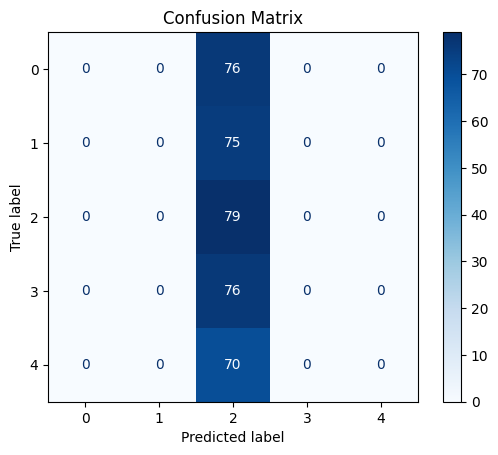

In [47]:
plot_confusion_matrix(y_val, preds, dummy_clf)

## Model 1: Logistic Regression

Simple logistic regression model for an improved baseline

In [210]:
# For model tuning

In [74]:
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED))
# lr_model = OneVsOneClassifier(LogisticRegression(random_state=SEED))

lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 87.13%
Precision: 88.14%
Recall: 87.13%
F1: 86.25%


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

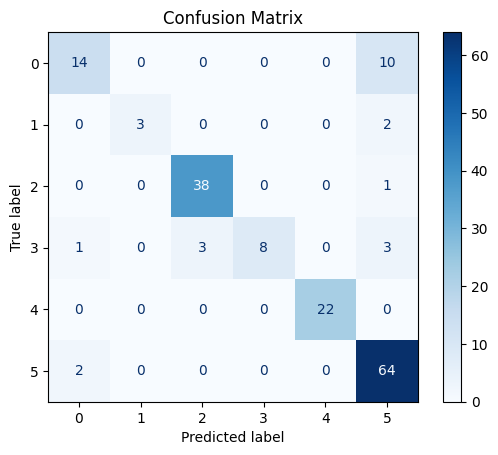

In [75]:
plot_confusion_matrix(y_val, preds, lr_model)

In [98]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED, max_iter=300))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  lr_model.fit(X_strat_train, y_strat_train)

  preds = lr_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)


========== Split 0 ==========
Accuracy: 87.63%
Precision: 87.92%
Recall: 87.63%
F1: 86.99%

========== Split 1 ==========


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Accuracy: 88.66000000000001%
Precision: 89.25%
Recall: 88.66000000000001%
F1: 87.91%

========== Split 2 ==========
Accuracy: 88.66000000000001%
Precision: 88.94%
Recall: 88.66000000000001%
F1: 88.32%

========== Split 3 ==========


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Accuracy: 87.63%
Precision: 89.03%
Recall: 87.63%
F1: 86.97%

========== Split 4 ==========
Accuracy: 84.54%
Precision: 83.26%
Recall: 84.54%
F1: 82.71%

========== Split 5 ==========


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Accuracy: 89.18%
Precision: 90.45%
Recall: 89.18%
F1: 88.75999999999999%

========== Split 6 ==========
Accuracy: 84.54%
Precision: 85.75%
Recall: 84.54%
F1: 83.77%

========== Split 7 ==========


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Accuracy: 87.63%
Precision: 89.28%
Recall: 87.63%
F1: 86.55000000000001%

========== Split 8 ==========
Accuracy: 85.05%
Precision: 85.98%
Recall: 85.05%
F1: 83.17%

========== Split 9 ==========


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 84.02%
Precision: 84.81%
Recall: 84.02%
F1: 82.35%


d:\Downloads\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


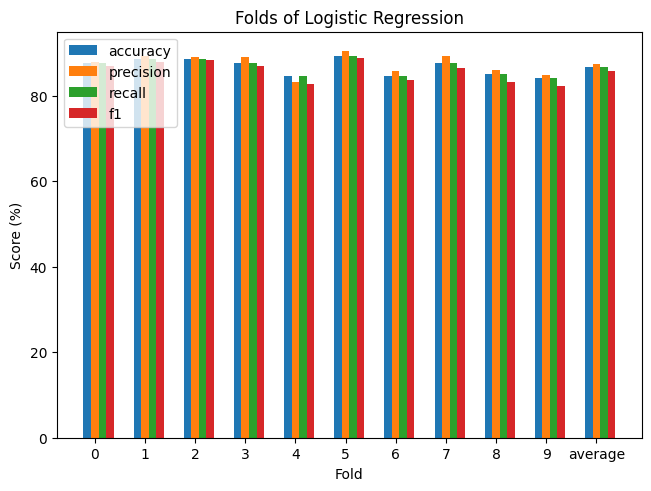

In [99]:
plot_folds(results, "Folds of Logistic Regression")

## Model 2: Decision Tree / Random Forest

Similar reason for decision tree except more interpretable. Random forest for boosting improvements

In [193]:
# For model tuning
config = {
  "max_depth": 10,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [194]:
dt_model = DecisionTreeClassifier(**config, random_state=SEED)

dt_model.fit(X_train, y_train)
preds = dt_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 92.97999999999999%
Precision: 93.31%
Recall: 92.97999999999999%
F1: 93.0%


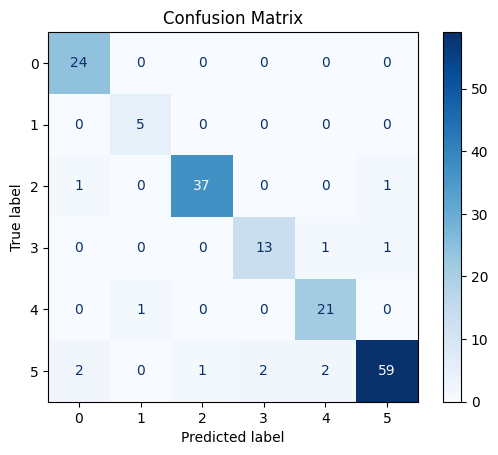

In [102]:
plot_confusion_matrix(y_val, preds, dt_model)

In [195]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
dt_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  dt_model.fit(X_strat_train, y_strat_train)

  preds = dt_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)


========== Split 0 ==========
Accuracy: 86.08%
Precision: 86.89%
Recall: 86.08%
F1: 85.65%

========== Split 1 ==========
Accuracy: 90.21000000000001%
Precision: 91.56%
Recall: 90.21000000000001%
F1: 90.09%

========== Split 2 ==========
Accuracy: 89.69%
Precision: 90.58%
Recall: 89.69%
F1: 89.62%

========== Split 3 ==========
Accuracy: 92.78%
Precision: 93.30000000000001%
Recall: 92.78%
F1: 92.89%

========== Split 4 ==========
Accuracy: 91.75%
Precision: 92.17999999999999%
Recall: 91.75%
F1: 91.7%

========== Split 5 ==========
Accuracy: 93.30000000000001%
Precision: 93.87%
Recall: 93.30000000000001%
F1: 93.21000000000001%

========== Split 6 ==========
Accuracy: 90.21000000000001%
Precision: 91.63%
Recall: 90.21000000000001%
F1: 90.11%

========== Split 7 ==========
Accuracy: 89.69%
Precision: 90.38000000000001%
Recall: 89.69%
F1: 89.61%

========== Split 8 ==========
Accuracy: 92.27%
Precision: 92.36999999999999%
Recall: 92.27%
F1: 92.17999999999999%

========== Split 9 =========

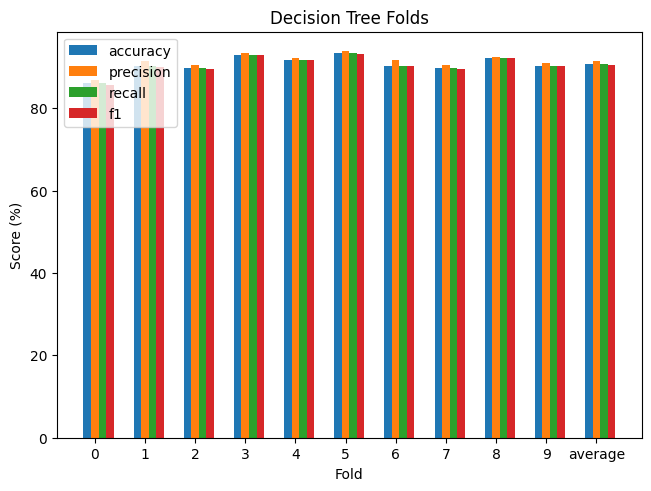

In [105]:
plot_folds(results, "Decision Tree Folds")

Random Forest Classifier

In [106]:
# For model tuning
config = {
  "n_estimators": 100,
  "max_depth": None,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [ ]:
rf_model = RandomForestClassifier(**config, random_state=SEED)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 97.08%
Precision: 97.3%
Recall: 97.08%
F1: 97.09%


In [108]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
rf_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  rf_model.fit(X_strat_train, y_strat_train)

  preds = rf_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)


========== Split 0 ==========
Accuracy: 86.08%
Precision: 86.89%
Recall: 86.08%
F1: 85.65%

========== Split 1 ==========
Accuracy: 90.21000000000001%
Precision: 91.56%
Recall: 90.21000000000001%
F1: 90.09%

========== Split 2 ==========
Accuracy: 89.69%
Precision: 90.58%
Recall: 89.69%
F1: 89.62%

========== Split 3 ==========
Accuracy: 92.78%
Precision: 93.30000000000001%
Recall: 92.78%
F1: 92.89%

========== Split 4 ==========
Accuracy: 91.75%
Precision: 92.17999999999999%
Recall: 91.75%
F1: 91.7%

========== Split 5 ==========
Accuracy: 93.30000000000001%
Precision: 93.87%
Recall: 93.30000000000001%
F1: 93.21000000000001%

========== Split 6 ==========
Accuracy: 90.21000000000001%
Precision: 91.63%
Recall: 90.21000000000001%
F1: 90.11%

========== Split 7 ==========
Accuracy: 89.69%
Precision: 90.38000000000001%
Recall: 89.69%
F1: 89.61%

========== Split 8 ==========
Accuracy: 92.27%
Precision: 92.36999999999999%
Recall: 92.27%
F1: 92.17999999999999%

========== Split 9 =========

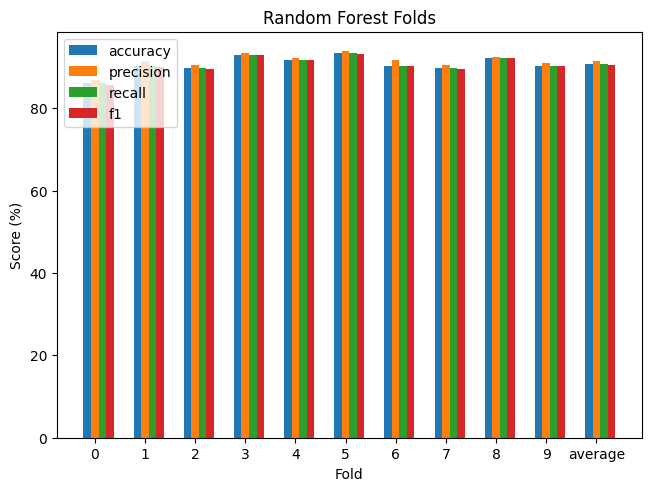

In [110]:
plot_folds(results, "Random Forest Folds")

## Model 3: XGBoost

Larger improvement over standard decision tree and random forest

In [111]:
config = {
  "num_class": 6,
  "n_estimators": 100,
  "max_depth": 2,
  "learning_rate": 1
}

In [112]:
xgb_model = XGBClassifier(**config, objective="multi:softmax", random_state=SEED)

xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 95.91%
Precision: 95.91%
Recall: 95.91%
F1: 95.86%


In [113]:
preds

array([5, 0, 3, 2, 3, 2, 5, 2, 4, 2, 5, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 5,
       5, 0, 5, 2, 5, 4, 5, 2, 2, 0, 5, 2, 5, 5, 0, 0, 0, 4, 2, 4, 0, 3,
       2, 2, 3, 3, 4, 5, 0, 5, 4, 0, 5, 0, 0, 5, 5, 4, 2, 0, 5, 5, 5, 1,
       2, 0, 5, 3, 4, 0, 0, 5, 4, 2, 5, 2, 2, 5, 1, 4, 5, 2, 1, 0, 3, 5,
       5, 5, 2, 2, 5, 5, 2, 3, 5, 2, 1, 0, 5, 5, 3, 4, 5, 0, 0, 5, 3, 5,
       5, 4, 0, 4, 5, 5, 2, 2, 5, 5, 5, 2, 5, 2, 4, 5, 2, 5, 3, 5, 0, 5,
       5, 5, 4, 3, 5, 0, 4, 5, 2, 5, 2, 2, 0, 4, 2, 5, 4, 5, 2, 5, 3, 2,
       5, 3, 5, 5, 4, 4, 2, 0, 0, 2, 2, 4, 5, 2, 2, 2, 4], dtype=int32)

Feature importance metrics in XGBoost Trees:

- `gain` - A measure of the improvement in model performance or reduction in loss achieved by using a specific feature to split a node in a decision tree
- `weight` - The number of times a feature is used to split the data across all trees

In [123]:
def plot_xgb_importance(data, title):
  sorted_data = dict(sorted(data.items(), key=lambda x: x[1]))

  features = list(sorted_data.keys())
  scores = list(sorted_data.values())

  # Plot importance graph
  fig, ax = plt.subplots(figsize=(10, 12))
  bars = ax.barh(features, scores)

  for bar in bars:
    width = bar.get_width()
    label = f"{width:.3f}"
    ax.text(
      width,
      bar.get_y() + bar.get_height() / 2,
      label,
      ha='left',
      va='center',
      fontsize=9,
    )
  
  ax.set_xlabel("Importance Score")
  ax.set_ylabel("Features")
  ax.set_title(title)
  plt.tight_layout()

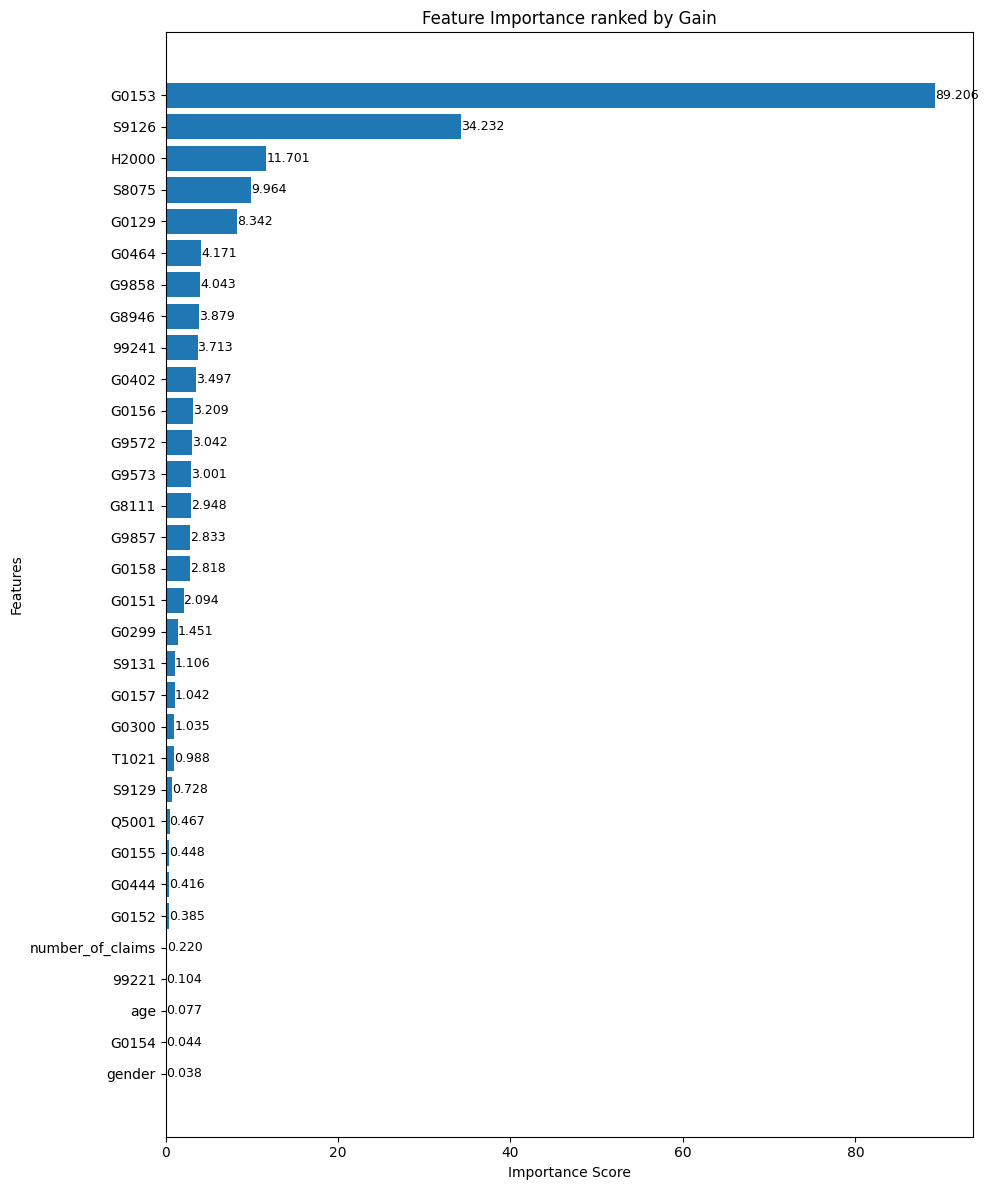

In [125]:
# Feature importance with built in XGBoost module
feature_importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
plot_xgb_importance(feature_importance_gain, "Feature Importance ranked by Gain")

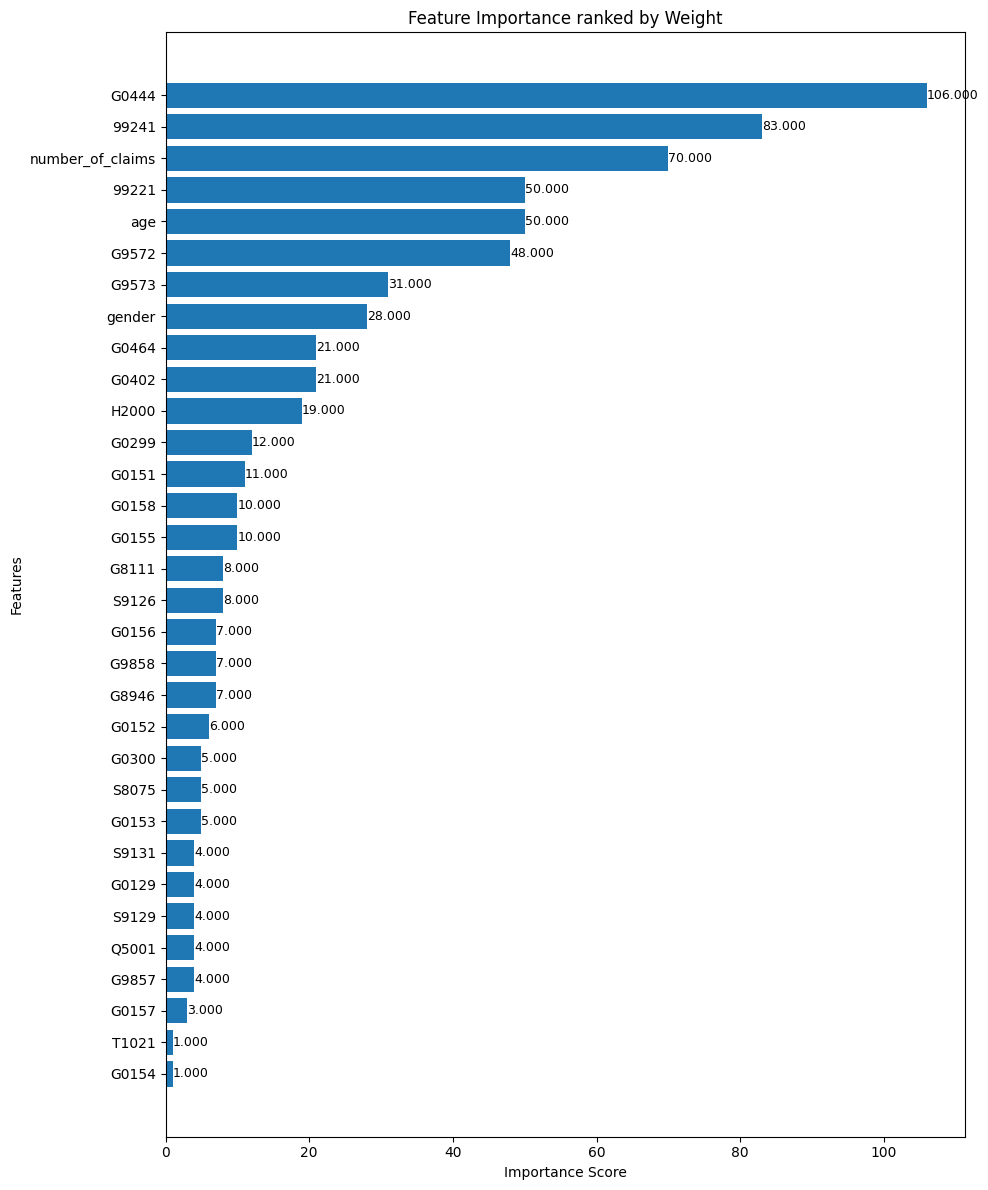

In [127]:
feature_importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
plot_xgb_importance(feature_importance_weight, "Feature Importance ranked by Weight")

## Model 4: FF Neural Network

NOTE: Workflow works, but output needs to be one hot encoded

In [179]:
import tensorflow as tf
import keras.models
from tensorflow import keras
from keras.layers import Input, Dense, ReLU, BatchNormalization, Dropout

In [181]:
# Parameters and Tuning
input_shape = (X_train.shape[1], ) # Number of columns
output_shape = 6 # Number of clusters (targets)
optimizer = "sgd"
loss = "categorical_crossentropy" # If target is label_encoded sparse_categorical_crossentropy
num_epochs = 50 

In [182]:
# Create one-hot encoding
y_train_oh = tf.one_hot(y_train, depth=output_shape)
y_val_oh = tf.one_hot(y_val, depth=output_shape)

In [183]:
inputs = Input(input_shape)

# 2 Layer MLP
dense_layer_1 = Dense(64)(inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
relu_1 = ReLU()(batch_norm_1)
dropout_1 = Dropout(rate=0.1)(relu_1)

dense_layer_2 = Dense(64)(dropout_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)
relu_2 = ReLU()(batch_norm_2)
dropout_2 = Dropout(rate=0.1)(relu_2)

outputs = Dense(output_shape, activation='softmax')(dropout_2)

model = keras.Model(inputs=inputs, outputs=outputs)

In [184]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,134 (31.77 KB)

 Trainable params: 7,878 (30.77 KB)

 Non-trainable params: 256 (1.00 KB)

In [185]:
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
  ]
)

In [186]:
history = model.fit(
  X_train,
  y_train_oh,
  validation_data=[X_val, y_val_oh],
  epochs=num_epochs
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - categorical_accuracy: 0.2374 - loss: 1.8403 - precision_4: 0.3371 - recall_4: 0.0377 - val_categorical_accuracy: 0.3860 - val_loss: 2.7622 - val_precision_4: 0.3860 - val_recall_4: 0.3860
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2977 - loss: 1.6852 - precision_4: 0.4231 - recall_4: 0.0415 - val_categorical_accuracy: 0.3860 - val_loss: 2.6869 - val_precision_4: 0.3860 - val_recall_4: 0.3860
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3241 - loss: 1.6282 - precision_4: 0.5086 - recall_4: 0.0741 - val_categorical_accuracy: 0.3860 - val_loss: 2.1880 - val_precision_4: 0.3860 - val_recall_4: 0.3860
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3681 - loss: 1.5653 - precision_4: 0.5538 - recall_4: 0.0905 - val_categorical_accuracy: 0.3860 - val_loss: 1.8338 - val_precision_4: 0.3860 - val_recall_4: 0.3860
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

In [188]:
history_dict = history.history
history_dict.keys()

dict_keys(['categorical_accuracy', 'loss', 'precision_4', 'recall_4', 'val_categorical_accuracy', 'val_loss', 'val_precision_4', 'val_recall_4'])

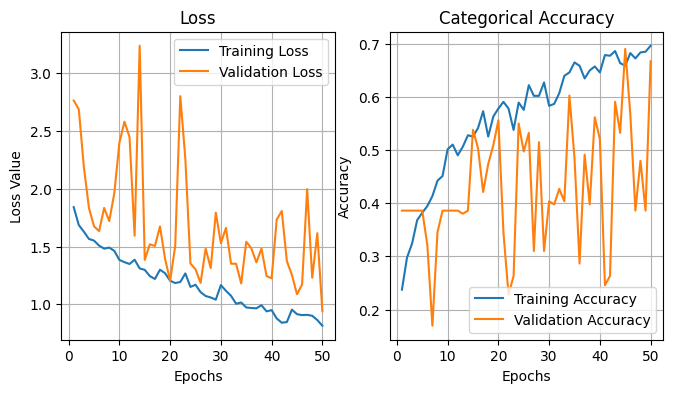

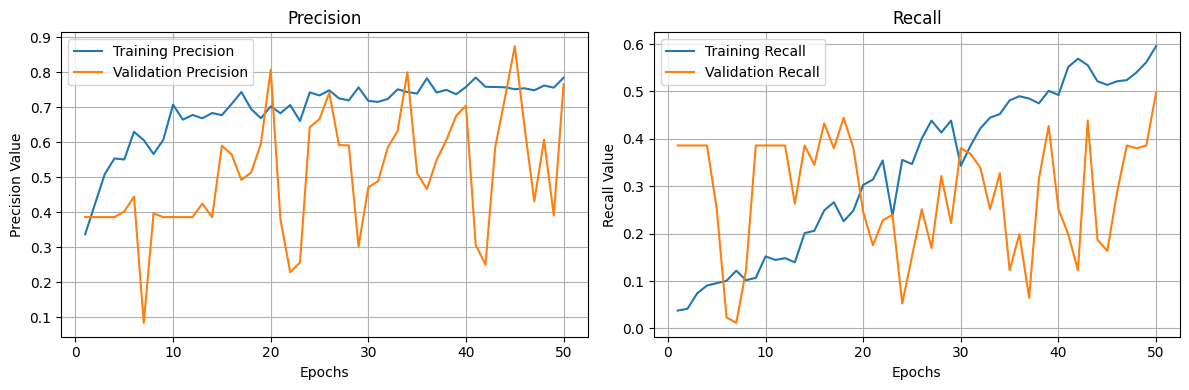

In [ ]:
# NOTE: Depending on the run number you have to change precision and recall values
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plotting for Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# Plotting for categorical accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict['categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Separate Precision and Recall plots
plt.figure(figsize=(12, 4))

# Plotting for Precision
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['precision'], label='Training Precision')
plt.plot(epochs, history_dict['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision Value')
plt.legend()
plt.grid(True)

# Plotting for Recall
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['recall'], label='Training Recall')
plt.plot(epochs, history_dict['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Feature Importance & Model Inspection

Explore the contributing factors of the model and evaluate the model's effectiveness in predictions

## Feature Importance

1. Decision tree visualisation + importance
2. Partial dependence plot
3. Permutation importance

### 1. Decision trees

- Plotted decision tree allows people to trace the path of the decision based on the feature values, making the results understandable
- Feature importance plot shows which feature caused the greatest reduction in variance of gini coefficient compared to their parent node, making that feature more important

In [190]:
from sklearn.tree import plot_tree

In [199]:
ovr = dt_model.estimators_[0]

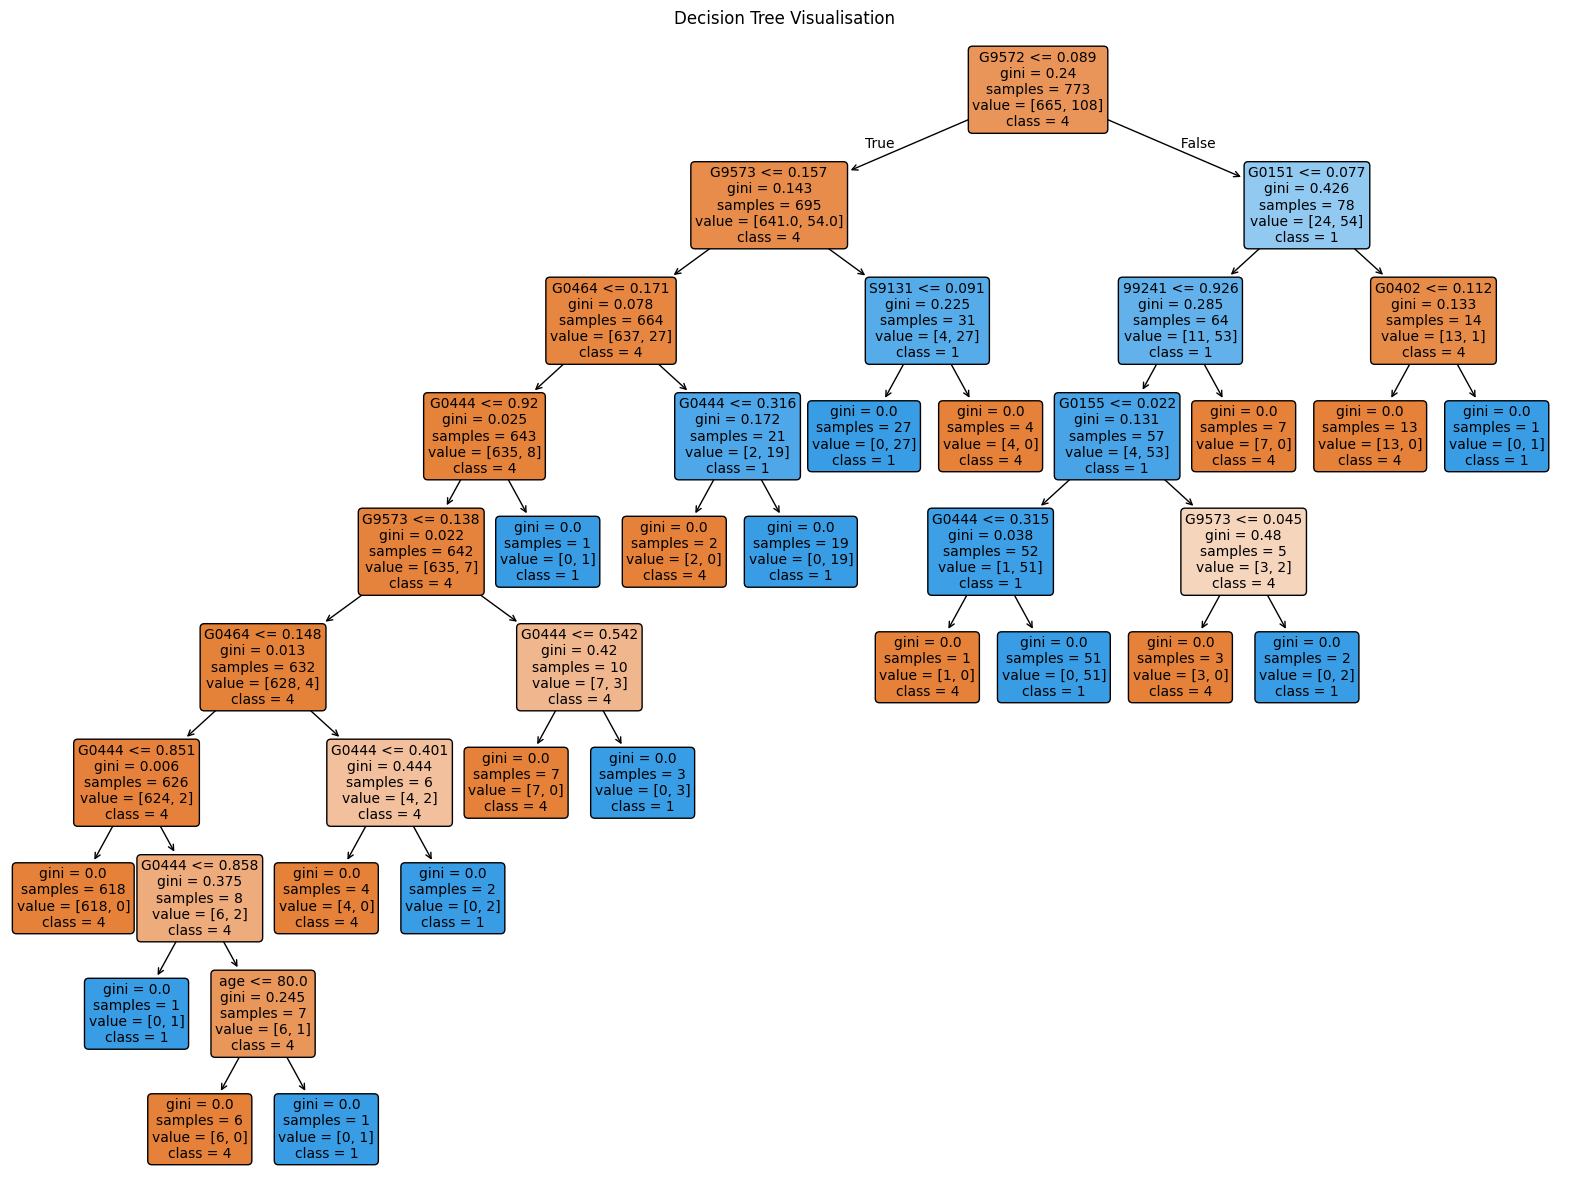

In [204]:
fig, ax = plt.subplots(figsize=(20, 15))
plot_tree(
  ovr,
  feature_names=X_train.columns,
  class_names=y_train.unique().astype(str),
  filled=True,
  rounded=True,
  fontsize=10
)
plt.title("Decision Tree Visualisation")
plt.show()

Text(0.5, 1.0, 'Feature Importance According to Decision Tree Model')

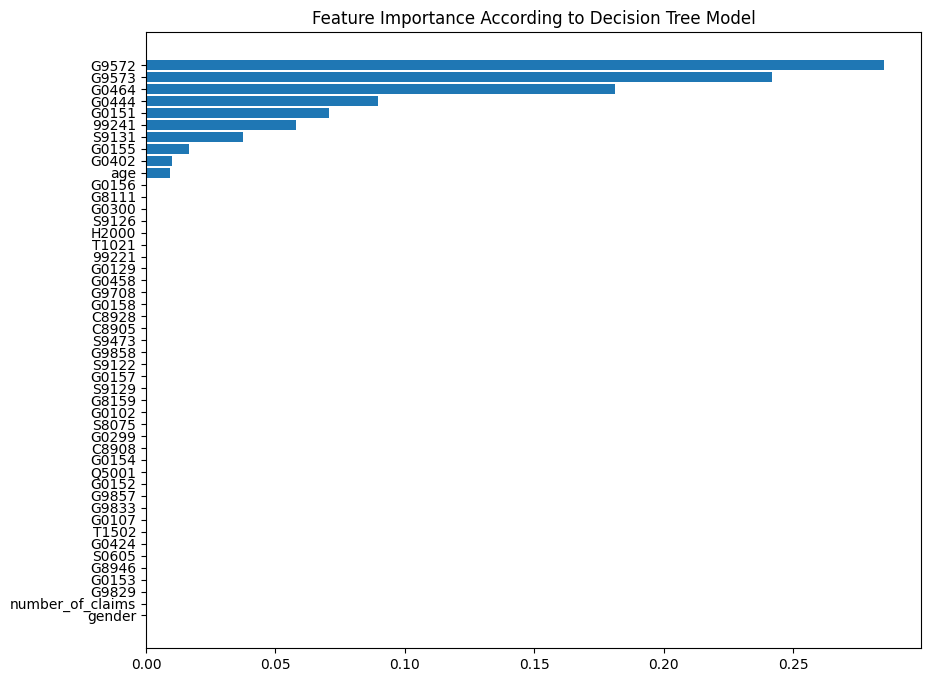

In [206]:
fig, ax = plt.subplots(figsize=(10, 8))
dt_importance = {k: v for k, v in zip(X_train.columns, ovr.feature_importances_)}
dt_importance = dict(sorted(dt_importance.items(), key=lambda kv: kv[1]))
plt.barh(dt_importance.keys(), dt_importance.values())
plt.title("Feature Importance According to Decision Tree Model")

### 2. Partial dependence plot

- PDP plots select a feature (or a set of features) and fix the average of all other features
- It then iterates through the range of the selected feature and produces a predicted value for each entry, with only the selected feature varying
- If there is a large fluctuation, then the feature is important

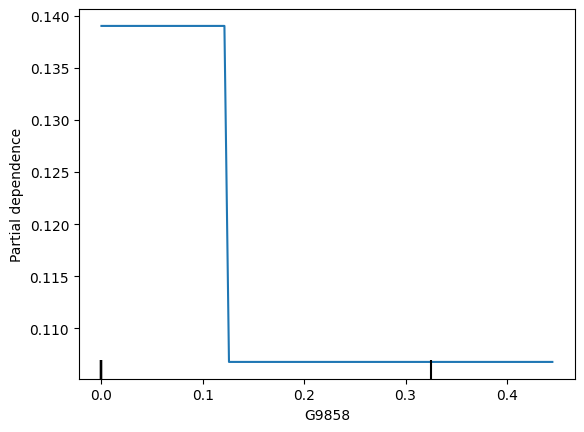

In [207]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
  estimator=rf_model,
  X=X_train,
  features=['G9858'],
  target=0
  # categorical_features=,
)


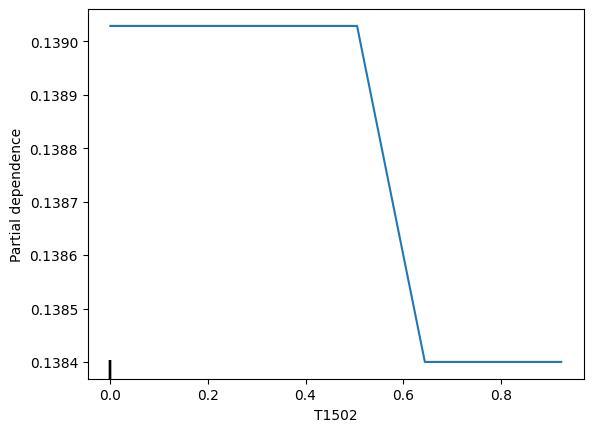

In [208]:
PartialDependenceDisplay.from_estimator(
  estimator=rf_model,
  X=X_train,
  features=['T1502'],
  target=0
  # categorical_features=,
)

### 3. Permutation importance

- Acts as a form of ablation study
- Similar to PDP plot but feature interactions are preserved (assuming the model automatically accounts for them)
- Select a feature and it randomly shuffles that feature values then makes predictions
- If the deviation from the true value increases significantly from the original model, then that feature is considered important

In [209]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

multiclass_scorer = make_scorer(precision_score, average='weighted')

result = permutation_importance(
  estimator=rf_model,
  X=X_test,
  y=y_test,
  scoring=multiclass_scorer,
  n_repeats=10,
  random_state=SEED
)

Text(0, 0.5, 'Feature')

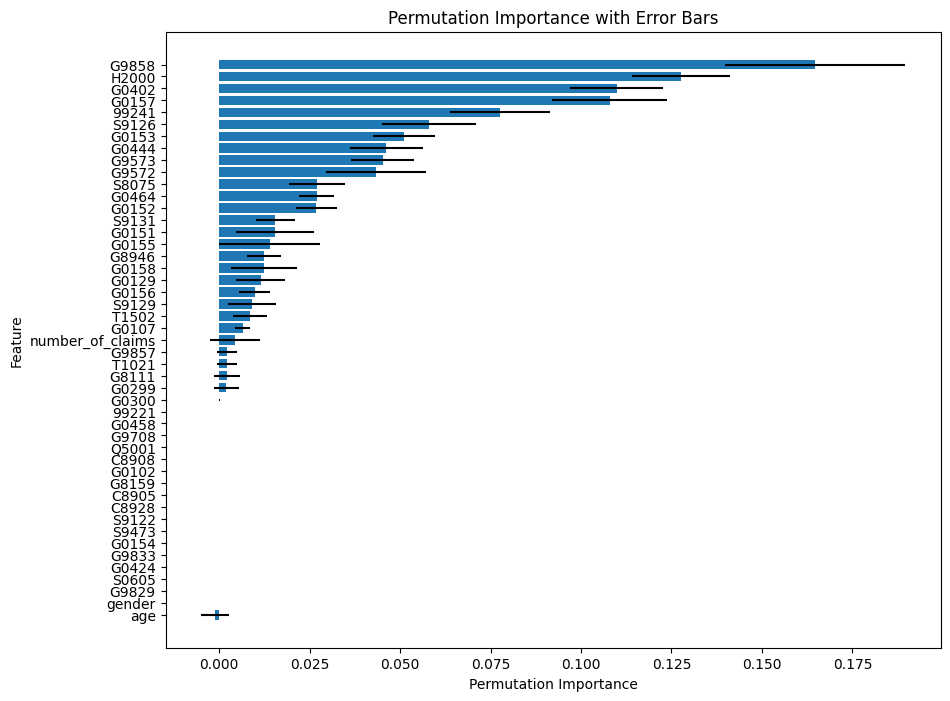

In [210]:
importance_means = result['importances_mean']
importance_std = result['importances_std']

sorted_idx = importance_means.argsort()
df_perm_impt = pd.DataFrame({
  "impt_mean": importance_means[sorted_idx],
  "impt_std": importance_std[sorted_idx],
  "feature": np.array(X_test.columns)[sorted_idx]
})

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(
  df_perm_impt['feature'],
  df_perm_impt['impt_mean'],
  xerr=df_perm_impt['impt_std'],
  align='center'
)
plt.title("Permutation Importance with Error Bars")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")

In [79]:
len(X_test.columns)

42

# Training Curves

Training data curves compare models with various sizes of training data to identify the overall impact on the model given a smaller dataset. Here we use varying percentages of training data to predict the validation data

The training data is also sampled from stratification. Data size ranges from 10-100% in increments of 10

In [247]:
def stratify_percentage_sample(X, y, percent, seed):
  rng = np.random.default_rng(seed=seed)

  idx = []
  for target in y.unique():
    y_sub = y[y == target]
    size = int(len(y_sub) * percent)
    indices = y_sub.index.to_series().sample(n=size, random_state=seed).index
    idx.append(list(indices))
  idx = [i for sublist in idx for i in sublist]
  rng.shuffle(idx)

  X_shuffle = X.loc[idx]
  y_shuffle = y.loc[idx]

  return X_shuffle, y_shuffle

In [256]:
# Run the stratified percentage sampling through the basic random forest classifier
percents = np.linspace(0.1, 1, num=10)
results = {
  "percentage": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}
for perc in percents:
  # For model tuning
  config = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1
  }
  rf_model = RandomForestClassifier(**config, random_state=SEED)

  X_sampled, y_sampled = stratify_percentage_sample(X_train, y_train, percent=perc, seed=SEED)
  rf_model.fit(X_sampled, y_sampled)
  preds = rf_model.predict(X_val)
  acc, prec, recall, f1 = metrics_score(y_val, preds)

  # Adding results
  results['percentage'].append(perc)
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)

d:\Downloads\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Text(0.5, 1.0, 'Metric Scores over Percentage of Data')

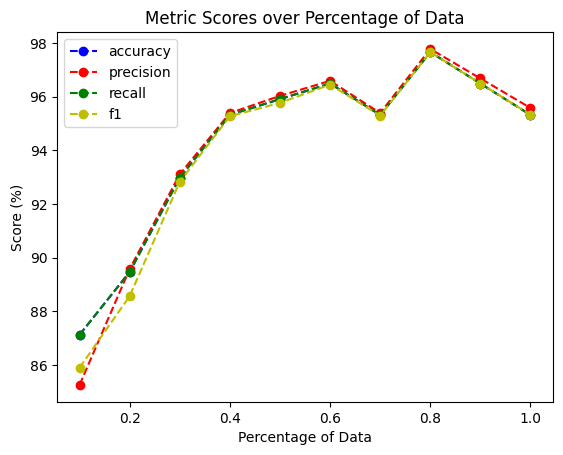

In [266]:
plt.plot(results['percentage'], results['accuracy'], 'bo--', label="accuracy")
plt.plot(results['percentage'], results['precision'], 'ro--', label="precision")
plt.plot(results['percentage'], results['recall'], 'go--', label="recall")
plt.plot(results['percentage'], results['f1'], 'yo--', label="f1")
plt.legend()
plt.ylabel("Score (%)")
plt.xlabel("Percentage of Data")
plt.title("Metric Scores over Percentage of Data")

# Sensitivity Analysis

# Failure Analysis

In [ ]:
%watermark